In [1]:
import os
import re
import string
import random
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer 

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn import tree
from sklearn.tree import export_text
import graphviz 
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.model_selection import train_test_split
import pmdarima as pm

# SENTIMENT ANALYSIS

## 1. Find the books which have the most positive reviews among the whole set (expecting ranking for the top 4 books)

In [2]:
reviews = pd.read_excel('data/Reviews.xlsx')

In [3]:
reviews.head()

,Comment,BookCode
0,"This is a self-published book, and if you want...",52979
1,I was a dissapointed to see errors on the back...,22722
2,A complete waste of time. Typographical errors...,52720
3,I feel I have to write to keep others from was...,32722
4,Excellent stockings for long shifts on your fe...,84987


In [5]:
reviews.shape

(112732, 2)

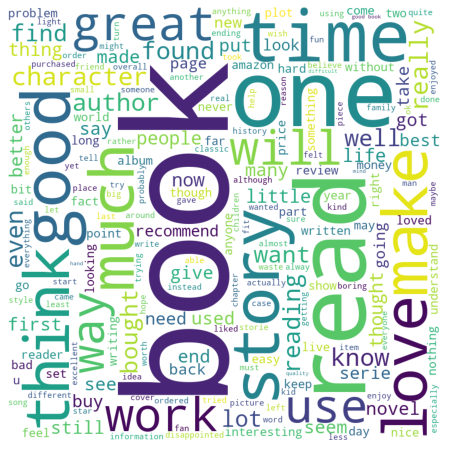

In [4]:
def wordcloud(df, col, stops):
    words = ' '
    for val in df[col]:
        val = str(val).lower()
        words += val + ' '
          
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color = 'white', 
                    stopwords = stops, 
                    min_font_size = 10).generate(words)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.show() 
        
wordcloud(reviews, 'Comment', set(STOPWORDS))

In [9]:
reviews['relevant'] = 0
#review['Comment'] = reviews['Comment'].fillna('Nothing')
reviews['Comment'] = reviews['Comment'].str.lower()

reviews.loc[reviews['Comment'].str.contains('book|words|author|publish|read|wrote|write|thesaurus|dictionary|series|plot|tale|story|written|novel|page|classic|bestseller|guide|text|edition|volume|magazine|issue',na=False),'relevant'] = 1

reviews.relevant.value_counts()
# reviews[reviews['relevant']!=1].to_csv('rejectReviews.csv',index=False)
# reviews[reviews['relevant']==1].to_csv('acceptReviews.csv',index=False)
len(reviews[reviews.relevant ==1])/ len(reviews)

0.6400844480715325

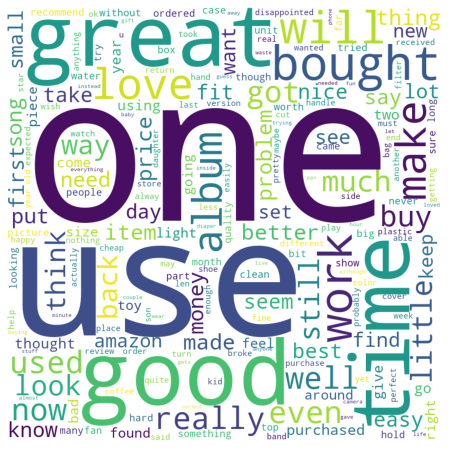

In [11]:
#Word Cloud which are not relevant to books 
wordcloud(reviews[reviews.relevant == 0], 'Comment', set(STOPWORDS))

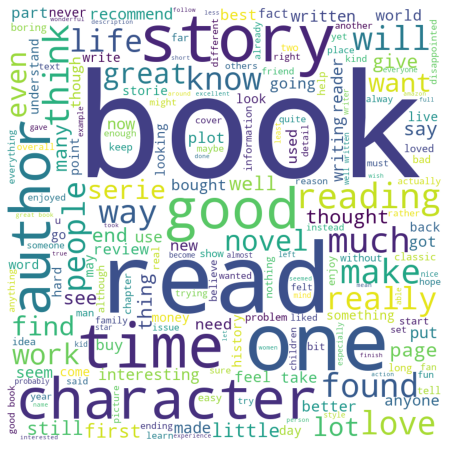

In [12]:
#Word Cloud which are relevant to books
wordcloud(reviews[reviews.relevant == 1], 'Comment', set(STOPWORDS))

In [14]:
rel_reviews = reviews[reviews.relevant == 1]
rel_reviews.shape

(72158, 3)

### Lemmatised and tokenised only words

In [15]:
lemmatizer = WordNetLemmatizer()
rel_reviews['lem_Comment'] = rel_reviews['Comment'].apply(lambda y:  ' '.join([(lemmatizer.lemmatize(i)) for i in y.split(" ")]) if type(y)==str else y)

<ipython-input-15-b5f99e4bf977>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_reviews['lem_Comment'] = rel_reviews['Comment'].apply(lambda y:  ' '.join([(lemmatizer.lemmatize(i)) for i in y.split(" ")]) if type(y)==str else y)


In [16]:
rel_reviews['lem_Comment'][0]

'this is a self-published book, and if you want to know why--read a few paragraphs! those 5 star review must have been written by ms. haddon\'s family and friends--or perhaps, by herself! i can\'t imagine anyone reading the whole thing--i spent an evening with the book and a friend and we were in hysteric reading bit and piece of it to one another. it is most definitely bad enough to be entered into some kind of a "worst book" contest. i can\'t believe amazon even sell this kind of thing. maybe i can offer them my 8th grade term paper on "to kill a mockingbird"--a book i am quite sure ms. haddon never heard of. anyway, unless you are in a mood to send a book to someone a a joke---stay far, far away from this one!'

### Sentiment analysis using textblob

In [17]:
nltk_tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
def split(text):
    sentences = text.split('. ')
    tokenized_sentences = [nltk_tokenizer.tokenize(sent) for sent in sentences]
    return tokenized_sentences
        
    
def textblob(sentences):
    for sentence in split(sentences):
        sentence = " ".join([ch for ch in sentence ])

        if sentence=='':
            return 0
        else:
            return TextBlob(sentence).sentiment[0]

scores=[textblob(i) if type(i)==str else 0 for i in rel_reviews['lem_Comment'] ]
rel_reviews['scores']=scores
rel_reviews['scores'] = [1 if(i>0) else 0 for i in rel_reviews['scores']]
df=pd.DataFrame(rel_reviews.groupby(['BookCode'])['scores'].sum())
df.reset_index(inplace=True)
df.sort_values(['scores'],ascending=False)

<ipython-input-17-6c403b7741a5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_reviews['scores']=scores
<ipython-input-17-6c403b7741a5>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_reviews['scores'] = [1 if(i>0) else 0 for i in rel_reviews['scores']]


,BookCode,scores
2,22979,5573
1,22722,5563
15,84987,5515
0,22720,5479
4,32722,1404
3,32720,1400
11,52979,1389
18,114987,1365
7,42722,1362
19,124987,1360


In [18]:
new_df=rel_reviews['BookCode'].value_counts().reset_index()
new_df.columns=['BookCode','Count']
new_df

,BookCode,Count
0,22722,7812
1,84987,7806
2,22979,7788
3,22720,7671
4,32720,2669
5,32722,2647
6,52979,2643
7,124987,2617
8,94987,2591
9,114987,2589


#### We calculate the normalised score by divinding the score of each book by the count of reviews for that book, to get a normalised score.

In [19]:
merge_df=df.merge(new_df,on=['BookCode'])
merge_df['normalised_score']=merge_df['scores']/merge_df['Count']
merge_df=merge_df.sort_values(['normalised_score'],ascending=False)
merge_df

,BookCode,scores,Count,normalised_score
2,22979,5573,7788,0.715588
0,22720,5479,7671,0.714248
1,22722,5563,7812,0.712110
15,84987,5515,7806,0.706508
7,42722,1362,2514,0.541766
5,32979,1360,2540,0.535433
6,42720,1343,2524,0.532092
4,32722,1404,2647,0.530412
17,104987,1316,2495,0.527455
18,114987,1365,2589,0.527231


In [20]:
books=merge_df['BookCode'][:4]
top4books=pd.DataFrame(columns=['Top 4 BookCode'])
top4books['Top 4 BookCode']=books
top4books

,Top 4 BookCode
2,22979
0,22720
1,22722
15,84987


### Result 1:
#### The top 4 books based on the positive reviews are the books with Book Code
- 22979
- 22720
- 22722
- 84987

### Alternative to check with VADER Sentiment and TextBlob attributes for top rated books

In [22]:
def sentiScore(df, col):
    Senti_TBpol, Senti_TBsub = [], []
    Senti_VdPOS, Senti_VdNEU, Senti_VdNEG, Senti_VdCOMP = [], [], [], []
    
    for row in df[col]:
        #Using TextBlob
        feedbck =TextBlob(row)
        Senti_TBpol.append(feedbck.sentiment.polarity)
        Senti_TBsub.append(feedbck.sentiment.subjectivity)
        
        #Vader Scores
        sid_pol = sid.polarity_scores(row)
        Senti_VdPOS.append(sid_pol['pos'])
        Senti_VdNEU.append(sid_pol['neu'])
        Senti_VdNEG.append(sid_pol['neg'])
        Senti_VdCOMP.append(sid_pol['compound'])
        
    df['Senti_TBpol'], df['Senti_TBsub'] = Senti_TBpol, Senti_TBsub
    df['Senti_VdPOS'], df['Senti_VdNEU'], df['Senti_VdNEG'] = Senti_VdPOS, Senti_VdNEU, Senti_VdNEG
    df['Senti_VdCOMP'] = Senti_VdCOMP
                                    
    return df
    
sentiScore_df = sentiScore(rel_reviews.copy(), 'lem_Comment')

In [23]:
# Provides a 3 dimensional(BookCode, Type of Sentiments, Different Statistical agreegators) view of the output
senti_df  = pd.DataFrame()
for BkCde in list(sentiScore_df['BookCode'].drop_duplicates()):
    t = sentiScore_df[sentiScore_df.BookCode == BkCde]
    senti_df = senti_df.append({'BookCode' : BkCde,
                                'ReviewCount' : len(t),
                                'TBPolarity-Mean' : t.Senti_TBpol.mean(),
                                'TBPolarity-Median' : t.Senti_TBpol.median(),
                                'VdComposite-Mean' : t.Senti_VdCOMP.mean(),
                                'VdComposite-Median' : t.Senti_VdCOMP.median(),
                                'VdPositive-Mean' : t.Senti_VdPOS.mean(),
                                'VdPositive-Median' : t.Senti_VdPOS.median(),
                               }, ignore_index = True)
    

senti_df.sort_values(['TBPolarity-Mean'],inplace=True,ascending=False)
senti_df.to_csv('output/Senti_df.csv',index=False)

In [24]:
senti_df.head(4)

,BookCode,ReviewCount,TBPolarity-Mean,TBPolarity-Median,VdComposite-Mean,VdComposite-Median,VdPositive-Mean,VdPositive-Median
4,22979.0,7788.0,0.262691,0.248938,0.675651,0.85910,0.197507,0.186
5,22720.0,7671.0,0.259621,0.250000,0.676824,0.85880,0.197534,0.185
15,84987.0,7806.0,0.259577,0.246145,0.662398,0.85910,0.196395,0.185
1,22722.0,7812.0,0.258864,0.246064,0.667375,0.85545,0.196406,0.183


## Result 1 alternative :

#### We are picking the top 4 books based on TBPolarity-Mean and the result would be the same if we considered the VdPositive-Mean score. Both scores are significantly higher for these 4 books.

# FORECASTING

## 2. Plan demand for the top shelf books for the upcoming 2 months across all the 21 states (given in data) of US

In [25]:
sales_train=pd.read_excel('data/Sales.xlsx',sheet_name='Train')
sales_test=pd.read_excel('data/Sales.xlsx',sheet_name='Test')

In [26]:
sales_train.head(3)

,Units Sold,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,Memorial,Independence,Labor,Thanksgiving,Christmas,BookCode
0,6187.0,10146.68,14.474543,Arizona,Week End 01-06-19,2019-01-06,1,0,0,0,0,0,0,0,0,22722
1,9123.0,15144.18,14.174504,Arizona,Week End 01-07-18,2018-01-07,1,0,0,0,0,0,0,0,0,22722
2,6236.0,8356.24,14.150096,Arizona,Week End 01-13-19,2019-01-13,0,0,0,0,0,0,0,0,0,22722


In [53]:
sales_train['isHoliday'] = sales_train[['NewYear', 'MLK', 'Presidents', 'GoodFriday', 'Memorial',
       'Independence', 'Labor', 'Thanksgiving', 'Christmas']].sum(axis=1)
sales_test['isHoliday'] = sales_test[['NewYear', 'MLK', 'Presidents', 'GoodFriday', 'Memorial',
       'Independence', 'Labor', 'Thanksgiving', 'Christmas']].sum(axis=1)
sales_train['isHoliday']

0        1
1        1
2        0
3        0
4        0
        ..
50815    0
50816    0
50817    0
50818    1
50819    1
Name: isHoliday, Length: 50820, dtype: int64

In [50]:
sales_test.head(3)

,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,Memorial,Independence,Labor,Thanksgiving,Christmas,BookCode
0,5123.0,14.106784,Arizona,Week End 11-03-19,2019-11-03,0,0,0,0,0,0,0,0,0,22722
1,10064.0,13.935992,Arizona,Week End 11-10-19,2019-11-10,0,0,0,0,0,0,0,0,0,22722
2,8299.0,13.792752,Arizona,Week End 11-17-19,2019-11-17,0,0,0,0,0,0,0,0,0,22722


In [54]:
#Filtering for the books
books=[84987,22979,22720,22722]
sales_temp_train=sales_train[sales_train['BookCode'].isin(books)]
sales_temp_test=sales_test[sales_test['BookCode'].isin(books)]

In [55]:
#Filtering for one combo of the book code and state to run model
sales_temp1_train=sales_temp_train[(sales_temp_train['State']=='Arizona') &(sales_temp_train['BookCode']==22722)]
sales_temp1_train.sort_values(['Week'],inplace=True)

sales_temp1_test=sales_temp_test[(sales_temp_test['State']=='Arizona') &(sales_temp_test['BookCode']==22722)]
sales_temp1_test.sort_values(['Week'],inplace=True)

## Stationary Test - Dickey Fuller

### We compared the ‘Test Statistic’ and the ‘Critical Value’ to check for the stationarity of the time series



In [56]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,week):

    #Determing rolling statistics
    rolmean = timeseries.rolling( window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(week,timeseries, color='blue',label='Original')
    mean = plt.plot(week,rolmean, color='red', label='Rolling Mean')
    std = plt.plot(week,rolstd, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


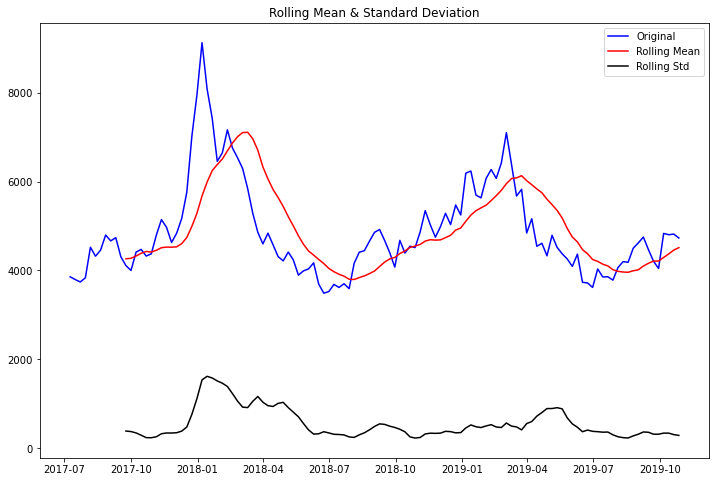

Results of Dickey-Fuller Test:
Test Statistic                  -3.433703
p-value                          0.009862
#Lags Used                      13.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [57]:
test_stationarity(sales_temp1_train['Units Sold'],sales_temp1_train['Week'])

## Seasonal decompose
### We leveraged the Seasonal Decompose package to inspect the time series components such as Trend, Seasonality and Residuals

In [58]:
sales_temp1_train['Week']

54    2017-07-09
57    2017-07-16
60    2017-07-23
63    2017-07-30
66    2017-08-06
         ...    
88    2019-09-29
91    2019-10-06
94    2019-10-13
97    2019-10-20
100   2019-10-27
Name: Week, Length: 121, dtype: datetime64[ns]

<Figure size 432x288 with 0 Axes>

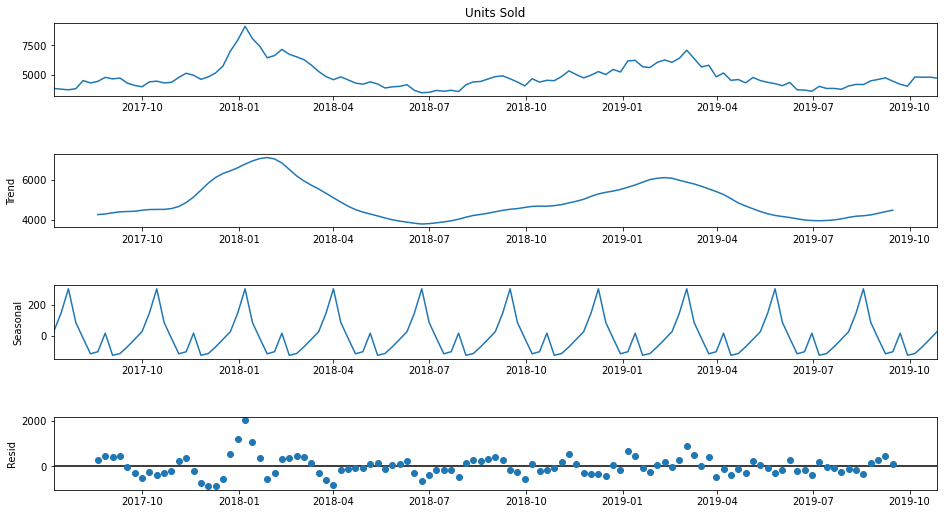

In [59]:
sales_temp1_train.index=sales_temp1_train['Week']

decomposition = seasonal_decompose(sales_temp1_train['Units Sold'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

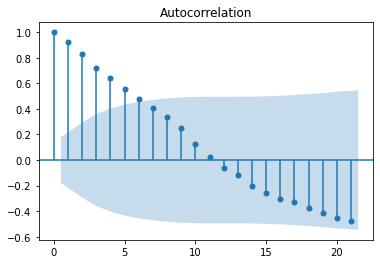

In [60]:
#ACF plots
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sales_temp1_train['Units Sold'])
plt.show()

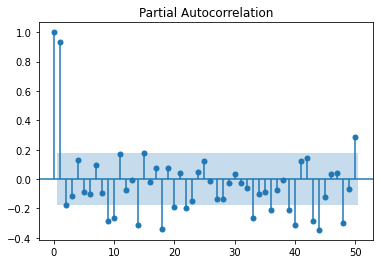

In [61]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(sales_temp1_train['Units Sold'], lags=50)
plt.show()

In [62]:
mod = SARIMAX(endog=sales_temp1_train['Units Sold'],exog=sales_temp1_train[sales_temp1_train.columns.difference(['Units Sold','Time','Week','State','diff'])], order=(0,1,0))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                  121
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -869.861
Date:                Sun, 24 Apr 2022   AIC                           1767.721
Time:                        17:26:59   BIC                           1806.746
Sample:                    07-09-2017   HQIC                          1783.569
                         - 10-27-2019                                         
Covariance Type:                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Available Books in the shelf     0.0425      0.029      1.462      0.144      -0.014       0.100
BookCode                      5.815e-11        nan        nan        nan     

## Automating the Whole process-Using pmdarima which automatically detects the order(AR,MA coefficients) and the seasonality order if present

### Running for the train test split to check the performance of our model by validating with AIC and BIC scores. Filtering for individual bookcodes and states and running with all possible combinations of exogenous variables ('Available Books in the shelf', 'Price' and 'isHoliday') and without any exogenous variable

#### An exogenous variable is a variable that is not affected by other variables in the system.

In [63]:
import warnings
import itertools
warnings.filterwarnings('ignore')
def train_test_split_fit(data,bookcode,states):
    mock=data.copy()
    for i in bookcode:
        for j in states:
            mock=data[(data['State']==j) &(data['BookCode']==i)]
            if len(mock)==0:
                continue
            print(f'Running for State:{j} and Bookcode:{i}')
            # Load/split your data
            y = mock['Units Sold'].reset_index(drop=True)
            train, test = train_test_split(y, train_size=0.8)
            for cols in list(itertools.chain(*map(lambda x: itertools.combinations(
                ['Available Books in the shelf', 'Price', 'isHoliday'], x), range(0, 4)))):
                if not cols:
                    print('Without exogenous')
                    # Fit model
                    model = pm.auto_arima(train, seasonal=True, m=52)

                    # make forecasts
                    forecasts = model.predict(test.shape[0])  # predict N steps into the future
                    
                else:
                    print(f'With exogenous columns {cols}')
                
                    # Fit model
                    model = pm.auto_arima(train, seasonal=True, m=52, exogenous=sales_temp1_train[list(cols)].reset_index(drop=True)[:len(train)])

                    # make forecasts
                    forecasts = model.predict(test.shape[0],exogenous=sales_temp1_train[list(cols)].reset_index(drop=True)[len(train):])  # predict N steps into the future
                print(f'AIC:{model.aic()},BIC:{model.bic()}')

In [64]:
train_test_split_fit(sales_train,books,sales_train.State.unique())

Running for State:Arizona and Bookcode:84987
Without exogenous
AIC:1781.599433498774,BIC:1789.2610641735757
With exogenous columns ('Available Books in the shelf',)
AIC:1783.2543713881207,BIC:1793.469878954523
With exogenous columns ('Price',)
AIC:1776.3822353766047,BIC:1786.597742943007
With exogenous columns ('isHoliday',)
AIC:1781.7966667690953,BIC:1792.0121743354975
With exogenous columns ('Available Books in the shelf', 'Price')
AIC:1778.4079394687133,BIC:1791.1773239267159
With exogenous columns ('Available Books in the shelf', 'isHoliday')
AIC:1783.5482858264759,BIC:1796.3176702844785
With exogenous columns ('Price', 'isHoliday')
AIC:1777.0714453070564,BIC:1789.840829765059
With exogenous columns ('Available Books in the shelf', 'Price', 'isHoliday')
AIC:1779.2221202171395,BIC:1802.2070122415444
Running for State:California and Bookcode:84987
Without exogenous
AIC:1993.2354213451938,BIC:1995.7892982367944
With exogenous columns ('Available Books in the shelf',)
AIC:1993.78025244

KeyboardInterrupt: 

In [65]:
def prediction(train_data, test_data, bookcode, states):
    mock_train=train_data.copy()
    mock_test=test_data.copy()
    for i in bookcode:
        for j in states:
            mock_train=train_data[(train_data['State']==j) &(train_data['BookCode']==i)]
            mock_test=test_data[(test_data['State']==j) &(test_data['BookCode']==i)]
            if len(mock_test)==0:
                continue                    
           
            # Fit the model
            model = pm.auto_arima(mock_train['Units Sold'], seasonal=True, m=52, exogenous=mock_train[['Available Books in the shelf', 'Price']].reset_index(drop=True))

            # make forecasts
            forecasts = model.predict(mock_test.shape[0],exogenous=mock_test[['Available Books in the shelf', 'Price']].reset_index(drop=True))  # predict N steps into the future
            test_data.loc[(test_data['State']==j) &(test_data['BookCode']==i),'Units Sold']=forecasts
    return (test_data)
    

In [67]:
out=prediction(sales_train,sales_test,books,sales_train.State.unique())

In [69]:
out[['State','Week','BookCode','Units Sold']].to_excel('Forecast_Output.xlsx',index=False)

# CUSTOMER PROFILING


In [70]:
sales = pd.read_excel('data/Sales.xlsx')
sales.columns

Index(['Units Sold', 'Available Books in the shelf', 'Price', 'State', 'Time',
       'Week', 'NewYear', 'MLK', 'Presidents', 'GoodFriday', 'Memorial',
       'Independence', 'Labor', 'Thanksgiving', 'Christmas', 'BookCode'],
      dtype='object')

In [77]:
salesTop4 = sales[sales.BookCode.isin([22720,22722,22979,84987])]
salesTop4 = salesTop4.groupby(['BookCode','State'],as_index=False)['Units Sold'].sum()
salesTop4 = salesTop4.pivot(index ='State', columns ='BookCode', values =['Units Sold']) 
salesTop4.columns = ['22720','22722','22979','84987']
salesTop4['22720_dist%'] = salesTop4['22720']*100/salesTop4['22720'].sum()
salesTop4['22722_dist%'] = salesTop4['22722']*100/salesTop4['22722'].sum()
salesTop4['22979_dist%'] = salesTop4['22979']*100/salesTop4['22979'].sum()
salesTop4['84987_dist%'] = salesTop4['84987']*100/salesTop4['84987'].sum()
salesTop4 

,22720,22722,22979,84987,22720_dist%,22722_dist%,22979_dist%,84987_dist%
State,,,,,,,,
Arizona,39530353.0,589011.0,16128367.0,4921576.0,3.890475,3.059885,4.131745,4.557353
California,137358824.0,2345784.0,73349815.0,13364194.0,13.518501,12.186238,18.790666,12.375173
Colorado,33895335.0,431207.0,13176354.0,3968926.0,3.335891,2.240100,3.375502,3.675205
Florida,147989775.0,3212136.0,49399044.0,13925137.0,14.564772,16.686896,12.654987,12.894603
Illinois,79292490.0,1430364.0,28813257.0,8810239.0,7.803762,7.430674,7.381345,8.158235
Indiana,21857432.0,356291.0,5759931.0,2825560.0,2.151152,1.850915,1.475572,2.616454
Kansas,18128590.0,293016.0,5361513.0,2323227.0,1.784169,1.522204,1.373506,2.151296
Maryland,61617864.0,1230131.0,24397233.0,7119549.0,6.064271,6.390473,6.250054,6.592665
Minnesota,24543015.0,241213.0,9434767.0,3042123.0,2.415460,1.253090,2.416987,2.816990


In [78]:
for code in  ['22720','22722','22979','84987']:
    print('BookCode:',code,'\nTop2States:',salesTop4.nlargest(2,code+'_dist%').index.tolist(),)

BookCode: 22720 
Top2States: ['Florida', 'California']
BookCode: 22722 
Top2States: ['Florida', 'New York']
BookCode: 22979 
Top2States: ['California', 'New York']
BookCode: 84987 
Top2States: ['Florida', 'California']


## From this we are able to understand that 
### - people from 'Florida', 'California' are more likely to buy book 22720,
### - people from 'Florida', 'New York' are more likely to buy book 22722,
### - people from 'California', 'New York' are more likely to buy book 22979,
### - people from 'Florida', 'California' are more likely to buy book 84987,
### based on the distribution of unit sales from these segments

In [79]:
salesTop4_holiday = sales[sales.BookCode.isin([22720,22722,22979,84987])]
salesTop4_holiday['GiftingHolidays'] = salesTop4_holiday[['NewYear','Thanksgiving','Christmas']].apply(lambda x: any(x) ,axis=1)
salesTop4_holiday = salesTop4_holiday.groupby(['GiftingHolidays','BookCode'],as_index=False)['Units Sold'].mean()
salesTop4_holiday = salesTop4_holiday.pivot(index ='GiftingHolidays', columns ='BookCode', values =['Units Sold']) 
salesTop4_holiday.columns = ['22720','22722','22979','84987']
salesTop4_holiday

,22720,22722,22979,84987
GiftingHolidays,,,,
False,400727.683230,7515.386335,153917.916356,42711.851346
True,383515.365079,8728.523810,147941.412698,38435.365079


## Similiarly, if we consider the average sales amount in weeks that have gift giving holidays vs the other weeks, we can see that 
### - customers are likely to buy book 22722 as a gift as the average units sold is higher during gift season
### - customers are least likely to buy book 84987 as a gift as the average units sold is lower during gift season
### - whereas the other books have more or less a similiar average distribution

In [112]:
customer = pd.read_excel('data/Customer.xlsx')
print(customer.columns,customer.shape) 
customer.head()

Index(['CustomerID', 'BookCode', 'Age'], dtype='object') (267615, 3)


,CustomerID,BookCode,Age
0,17850,32722,19
1,17850,32979,19
2,17850,94987,19
3,17850,32720,19
4,17850,42722,19


In [113]:
customer["Age"].describe()

count    267615.000000
mean         47.456918
std           8.141572
min          11.000000
25%          41.000000
50%          48.000000
75%          54.000000
max          81.000000
Name: Age, dtype: float64

In [114]:
customer["Age"].isnull().sum()

0

In [115]:
customerTop4 = customer[customer.BookCode.isin([22722,22979,22720,84987])]
print(customerTop4.shape)
customerTop4.head()

(1461, 3)


,CustomerID,BookCode,Age
3733,16891,84987,43
6256,15426,84987,50
10307,16081,84987,40
11222,15005,84987,50
13791,17912,84987,47


In [116]:
customerTop4.groupby("BookCode")["Age"].mean()

BookCode
22720    46.589062
22722    46.463104
22979    46.293333
84987    47.000000
Name: Age, dtype: float64

In [117]:
customerTop4

,CustomerID,BookCode,Age
3733,16891,84987,43
6256,15426,84987,50
10307,16081,84987,40
11222,15005,84987,50
13791,17912,84987,47
...,...,...,...
265974,15525,22722,51
266295,17631,22722,45
266620,17436,22979,38
267000,14415,22979,47


In [118]:
customerTop4.groupby("BookCode")["Age"].median()

BookCode
22720    47
22722    47
22979    47
84987    48
Name: Age, dtype: int64

(array([  2.,  30.,  20., 219., 394., 366., 368.,  57.,   0.,   5.]),
 array([11., 18., 25., 32., 39., 46., 53., 60., 67., 74., 81.]),
 <BarContainer object of 10 artists>)

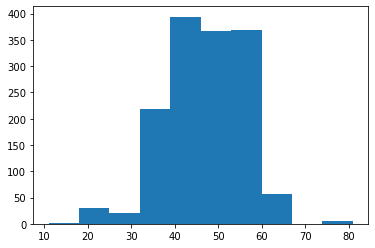

In [119]:
plt.hist(customerTop4['Age'])

### Trying out Decision Tree for getting age bins for each BookCode

In [142]:
customerTop4.dtypes

CustomerID    int64
BookCode      int64
Age           int64
dtype: object

In [141]:
customerTop4['BookCode']=customerTop4['BookCode'].astype(int)

In [143]:
clf = DecisionTreeClassifier(class_weight='balanced')
clf = clf.fit(pd.DataFrame(customerTop4['Age']), customerTop4['BookCode'])

In [144]:
r = export_text(clf)
print(r)

|--- feature_0 <= 48.50
|   |--- feature_0 <= 43.50
|   |   |--- feature_0 <= 32.00
|   |   |   |--- feature_0 <= 18.50
|   |   |   |   |--- feature_0 <= 14.50
|   |   |   |   |   |--- class: 22722
|   |   |   |   |--- feature_0 >  14.50
|   |   |   |   |   |--- class: 22979
|   |   |   |--- feature_0 >  18.50
|   |   |   |   |--- feature_0 <= 28.50
|   |   |   |   |   |--- feature_0 <= 20.50
|   |   |   |   |   |   |--- feature_0 <= 19.50
|   |   |   |   |   |   |   |--- class: 22722
|   |   |   |   |   |   |--- feature_0 >  19.50
|   |   |   |   |   |   |   |--- class: 22722
|   |   |   |   |   |--- feature_0 >  20.50
|   |   |   |   |   |   |--- feature_0 <= 23.50
|   |   |   |   |   |   |   |--- feature_0 <= 22.50
|   |   |   |   |   |   |   |   |--- feature_0 <= 21.50
|   |   |   |   |   |   |   |   |   |--- class: 84987
|   |   |   |   |   |   |   |   |--- feature_0 >  21.50
|   |   |   |   |   |   |   |   |   |--- class: 22720
|   |   |   |   |   |   |   |--- feature_0 >  22.50


### Since there was only one feature, decision tree didn't yield proper results. Hence, we're going ahead with creating bins manually wrt the distribution of data.

### Binning based on the age group categories

In [106]:
bins = [1, 12, 17, 29, 39, 49, 59, 100]
labels = ['1-12','13-17','18-29', '30-39', '40-49','50-59', '60+']
customerTop4['AgeBin'] = pd.cut(customerTop4.Age, bins, labels = labels,include_lowest = True)
customerTop4 = customerTop4.groupby(['BookCode','AgeBin'],as_index=False).CustomerID.count()
customerTop4.CustomerID = customerTop4.CustomerID.fillna(0)

totals = customerTop4.groupby(['AgeBin'],as_index=False).CustomerID.sum()
totals.rename(columns={'CustomerID':'CustomerID_totalsByAgeBin'},inplace=True)
customerTop4 = customerTop4.merge(totals,on=['AgeBin'],how='left')

totals = customerTop4.groupby(['BookCode'],as_index=False).CustomerID.sum()
totals.rename(columns={'CustomerID':'CustomerID_totalsByBookCode'},inplace=True)
customerTop4 = customerTop4.merge(totals,on=['BookCode'],how='left')

customerTop4 = customerTop4.loc[customerTop4['CustomerID']>=customerTop4['CustomerID_totalsByBookCode']/7,]



customerTop4['CustomerIDDist%'] = customerTop4.CustomerID*100/customerTop4.CustomerID_totalsByAgeBin

customerTop4.head(7)

,BookCode,AgeBin,CustomerID,CustomerID_totalsByAgeBin,CustomerID_totalsByBookCode,CustomerIDDist%
3,22720,30-39,119,278,640,42.805755
4,22720,40-49,239,546,640,43.772894
5,22720,50-59,228,523,640,43.594646
10,22722,30-39,70,278,393,25.179856
11,22722,40-49,151,546,393,27.655678
12,22722,50-59,142,523,393,27.151052
17,22979,30-39,51,278,225,18.345324


In [107]:
customerTop4.sort_values(['BookCode','CustomerIDDist%'],inplace=True,ascending =False)
customerTop4 = customerTop4.groupby(['BookCode'],as_index=False).head(1)
customerTop4

,BookCode,AgeBin,CustomerID,CustomerID_totalsByAgeBin,CustomerID_totalsByBookCode,CustomerIDDist%
26,84987,50-59,77,523,203,14.722753
17,22979,30-39,51,278,225,18.345324
11,22722,40-49,151,546,393,27.655678
4,22720,40-49,239,546,640,43.772894


## From the above analysis we can determine that
### - people in the age range 50-59 are more likely to buy 84987 out of the 4 books
### - people in the age range 30-39 are more likely to buy 22979 out of the 4 books
### - people in the age range 40-49 are more likely to buy 22722 and 22720 out of the 4 books